In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/time domain /RAW/Total_time.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

In [ ]:
# %%capture
# !pip install wandb

In [ ]:
# import wandb

In [ ]:
# !wandb login

# CNN-LSTM

In [ ]:
%%capture
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/CNN_Lstm/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/CNN_Lstm/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 18, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 256)            0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 85ms/step - loss: 1.3944 - accuracy: 0.6385 - val_loss: 1.3743 - val_accuracy: 0.7144
Epoch 2/100
29/29 [==============================] - 1s 44ms/step - loss: 1.2441 - accuracy: 0.7355 - val_loss: 1.3077 - val_accuracy: 0.7565
Epoch 3/100
29/29 [==============================] - 1s 22ms/step - loss: 1.1431 - accuracy: 0.7527 - val_loss: 1.2675 - val_accuracy: 0.7791
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 1.0843 - accuracy: 0.7686 - val_loss: 1.2246 - val_accuracy: 0.7812
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 1.0227 - accuracy: 0.7858 - val_loss: 1.1840 - val_accuracy: 0.8157
Epoch 6/100
29/29 [==============================] - 0s 12ms/step - loss: 0.9805 - accuracy: 0.7920 - val_loss: 1.1416 - val_accuracy: 0.8050
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.9368 - accuracy: 0.7982 - val_loss: 1.1053 - val_accuracy: 0.7834
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 81ms/step - loss: 1.4006 - accuracy: 0.6254 - val_loss: 1.3766 - val_accuracy: 0.6855
Epoch 2/100
28/28 [==============================] - 1s 29ms/step - loss: 1.2838 - accuracy: 0.7083 - val_loss: 1.3180 - val_accuracy: 0.7149
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 1.1754 - accuracy: 0.7284 - val_loss: 1.2733 - val_accuracy: 0.7398
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 1.0983 - accuracy: 0.7550 - val_loss: 1.2302 - val_accuracy: 0.7738
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 1.0449 - accuracy: 0.7663 - val_loss: 1.1941 - val_accuracy: 0.6742
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.9866 - accuracy: 0.7906 - val_loss: 1.1560 - val_accuracy: 0.7590
Epoch 7/100
28/28 [==============================] - 1s 31ms/step - loss: 0.9424 - accuracy: 0.7999 - val_loss: 1.1174 - val_accuracy: 0.7851
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 10s 55ms/step - loss: 1.3979 - accuracy: 0.5649 - val_loss: 1.3705 - val_accuracy: 0.6343
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 1.2685 - accuracy: 0.6855 - val_loss: 1.3089 - val_accuracy: 0.7035
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 1.1459 - accuracy: 0.7380 - val_loss: 1.2616 - val_accuracy: 0.7128
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 1.0645 - accuracy: 0.7667 - val_loss: 1.2152 - val_accuracy: 0.7562
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.9977 - accuracy: 0.7837 - val_loss: 1.1727 - val_accuracy: 0.7944
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 0.9598 - accuracy: 0.7791 - val_loss: 1.1321 - val_accuracy: 0.7872
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.9059 - accuracy: 0.7977 - val_loss: 1.0907 - val_accuracy: 0.7469
Epoch 8/100
31/31

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 79ms/step - loss: 0.3853 - accuracy: 0.8518 - val_loss: 0.7228 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2790 - accuracy: 0.9027 - val_loss: 0.7156 - val_accuracy: 0.5603
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2483 - accuracy: 0.9165 - val_loss: 0.7124 - val_accuracy: 0.8039
Epoch 4/100
29/29 [==============================] - 1s 26ms/step - loss: 0.2241 - accuracy: 0.9305 - val_loss: 0.6973 - val_accuracy: 0.8610
Epoch 5/100
29/29 [==============================] - 1s 17ms/step - loss: 0.2328 - accuracy: 0.9224 - val_loss: 0.6876 - val_accuracy: 0.8502
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 0.1876 - accuracy: 0.9456 - val_loss: 0.6771 - val_accuracy: 0.8125
Epoch 7/100
29/29 [==============================] - 1s 29ms/step - loss: 0.1680 - accuracy: 0.9512 - val_loss: 0.6536 - val_accuracy: 0.8739
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 60ms/step - loss: 0.3841 - accuracy: 0.8548 - val_loss: 0.7242 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.3055 - accuracy: 0.8945 - val_loss: 0.7183 - val_accuracy: 0.5973
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.2443 - accuracy: 0.9222 - val_loss: 0.7128 - val_accuracy: 0.5781
Epoch 4/100
28/28 [==============================] - 1s 27ms/step - loss: 0.2333 - accuracy: 0.9264 - val_loss: 0.7024 - val_accuracy: 0.8043
Epoch 5/100
28/28 [==============================] - 1s 24ms/step - loss: 0.1909 - accuracy: 0.9423 - val_loss: 0.6889 - val_accuracy: 0.8281
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 0.1734 - accuracy: 0.9510 - val_loss: 0.6771 - val_accuracy: 0.7217
Epoch 7/100
28/28 [==============================] - 0s 14ms/step - loss: 0.2147 - accuracy: 0.9293 - val_loss: 0.6798 - val_accuracy: 0.7771
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 55ms/step - loss: 0.3739 - accuracy: 0.8525 - val_loss: 0.7237 - val_accuracy: 0.4876
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 0.3115 - accuracy: 0.8860 - val_loss: 0.7176 - val_accuracy: 0.6374
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.2633 - accuracy: 0.9057 - val_loss: 0.7082 - val_accuracy: 0.8192
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.2262 - accuracy: 0.9300 - val_loss: 0.6956 - val_accuracy: 0.8461
Epoch 5/100
31/31 [==============================] - 3s 98ms/step - loss: 0.2161 - accuracy: 0.9289 - val_loss: 0.6830 - val_accuracy: 0.8533
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.2104 - accuracy: 0.9341 - val_loss: 0.6697 - val_accuracy: 0.8275
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: 0.2036 - accuracy: 0.9354 - val_loss: 0.6583 - val_accuracy: 0.8326
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 9s 103ms/step - loss: 0.1821 - accuracy: 0.9539 - val_loss: 0.6876 - val_accuracy: 0.8147
Epoch 2/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0645 - accuracy: 0.9860 - val_loss: 0.6789 - val_accuracy: 0.8394
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0457 - accuracy: 0.9930 - val_loss: 0.6687 - val_accuracy: 0.8341
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0364 - accuracy: 0.9965 - val_loss: 0.6466 - val_accuracy: 0.8653
Epoch 5/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0405 - accuracy: 0.9927 - val_loss: 0.6366 - val_accuracy: 0.8125
Epoch 6/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0478 - accuracy: 0.9903 - val_loss: 0.6155 - val_accuracy: 0.8427
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0457 - accuracy: 0.9919 - val_loss: 0.5893 - val_accuracy: 0.8200
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 63ms/step - loss: 0.2163 - accuracy: 0.9437 - val_loss: 0.6882 - val_accuracy: 0.7647
Epoch 2/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0620 - accuracy: 0.9890 - val_loss: 0.6818 - val_accuracy: 0.7998
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0472 - accuracy: 0.9909 - val_loss: 0.6677 - val_accuracy: 0.8156
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0357 - accuracy: 0.9975 - val_loss: 0.6548 - val_accuracy: 0.8247
Epoch 5/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0319 - accuracy: 0.9983 - val_loss: 0.6350 - val_accuracy: 0.8394
Epoch 6/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0314 - accuracy: 0.9975 - val_loss: 0.6122 - val_accuracy: 0.8462
Epoch 7/100
28/28 [==============================] - 2s 91ms/step - loss: 0.0317 - accuracy: 0.9963 - val_loss: 0.5765 - val_accuracy: 0.8484
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 62ms/step - loss: 0.1687 - accuracy: 0.9522 - val_loss: 0.6867 - val_accuracy: 0.8347
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0613 - accuracy: 0.9858 - val_loss: 0.6763 - val_accuracy: 0.8357
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 0.0438 - accuracy: 0.9933 - val_loss: 0.6618 - val_accuracy: 0.8430
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0356 - accuracy: 0.9972 - val_loss: 0.6422 - val_accuracy: 0.8399
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0438 - accuracy: 0.9917 - val_loss: 0.6144 - val_accuracy: 0.8636
Epoch 6/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0428 - accuracy: 0.9915 - val_loss: 0.5833 - val_accuracy: 0.8647
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0538 - accuracy: 0.9866 - val_loss: 0.5643 - val_accuracy: 0.8368
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 10s 56ms/step - loss: 0.1104 - accuracy: 0.9642 - val_loss: 0.6783 - val_accuracy: 0.7672
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0380 - accuracy: 0.9908 - val_loss: 0.6723 - val_accuracy: 0.7317
Epoch 3/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0208 - accuracy: 0.9981 - val_loss: 0.6536 - val_accuracy: 0.8276
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0153 - accuracy: 0.9995 - val_loss: 0.6340 - val_accuracy: 0.8448
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.6080 - val_accuracy: 0.8642
Epoch 6/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 0.9997 - val_loss: 0.5766 - val_accuracy: 0.8524
Epoch 7/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.5361 - val_accuracy: 0.8621
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 61ms/step - loss: 0.0869 - accuracy: 0.9776 - val_loss: 0.6814 - val_accuracy: 0.6403
Epoch 2/100
28/28 [==============================] - 1s 26ms/step - loss: 0.0277 - accuracy: 0.9952 - val_loss: 0.6712 - val_accuracy: 0.7172
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0185 - accuracy: 0.9992 - val_loss: 0.6605 - val_accuracy: 0.7070
Epoch 4/100
28/28 [==============================] - 1s 31ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.6366 - val_accuracy: 0.7941
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0155 - accuracy: 0.9989 - val_loss: 0.6191 - val_accuracy: 0.7466
Epoch 6/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0152 - accuracy: 0.9989 - val_loss: 0.5793 - val_accuracy: 0.8156
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0531 - accuracy: 0.9864 - val_loss: 0.5683 - val_accuracy: 0.7919
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 74ms/step - loss: 0.0657 - accuracy: 0.9801 - val_loss: 0.6773 - val_accuracy: 0.7676
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0376 - accuracy: 0.9910 - val_loss: 0.6651 - val_accuracy: 0.8481
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0186 - accuracy: 0.9990 - val_loss: 0.6404 - val_accuracy: 0.8554
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0242 - accuracy: 0.9964 - val_loss: 0.6187 - val_accuracy: 0.8006
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0439 - accuracy: 0.9876 - val_loss: 0.6018 - val_accuracy: 0.8450
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0305 - accuracy: 0.9938 - val_loss: 0.5683 - val_accuracy: 0.8616
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0313 - accuracy: 0.9933 - val_loss: 0.5364 - val_accuracy: 0.8182
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 58ms/step - loss: 0.0647 - accuracy: 0.9836 - val_loss: 0.6713 - val_accuracy: 0.7931
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0205 - accuracy: 0.9973 - val_loss: 0.6589 - val_accuracy: 0.8416
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0122 - accuracy: 0.9989 - val_loss: 0.6438 - val_accuracy: 0.8362
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0129 - accuracy: 0.9984 - val_loss: 0.6205 - val_accuracy: 0.8319
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0129 - accuracy: 0.9987 - val_loss: 0.5870 - val_accuracy: 0.8265
Epoch 6/100
29/29 [==============================] - 0s 13ms/step - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.5463 - val_accuracy: 0.8222
Epoch 7/100
29/29 [==============================] - 0s 12ms/step - loss: 0.0329 - accuracy: 0.9914 - val_loss: 0.5349 - val_accuracy: 0.8341
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 58ms/step - loss: 0.0827 - accuracy: 0.9726 - val_loss: 0.6727 - val_accuracy: 0.8111
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0183 - accuracy: 0.9966 - val_loss: 0.6648 - val_accuracy: 0.8043
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.6492 - val_accuracy: 0.8235
Epoch 4/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.6289 - val_accuracy: 0.8213
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.6060 - val_accuracy: 0.8303
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.5751 - val_accuracy: 0.8326
Epoch 7/100
28/28 [==============================] - 1s 24ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.5385 - val_accuracy: 0.8462
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 80ms/step - loss: 0.0784 - accuracy: 0.9762 - val_loss: 0.6713 - val_accuracy: 0.7634
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0173 - accuracy: 0.9984 - val_loss: 0.6583 - val_accuracy: 0.8244
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.6399 - val_accuracy: 0.8202
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.6161 - val_accuracy: 0.8419
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.5858 - val_accuracy: 0.8182
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.8564
Epoch 7/100
31/31 [==============================] - 3s 116ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.5026 - val_accuracy: 0.8688
Epoch 8/100
31/31

In [ ]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.760,0.739,0.806,0.771,0.806,0.715,0.521
1,1,0.802,0.812,0.787,0.799,0.787,0.818,0.605
2,2,0.728,0.707,0.779,0.741,0.779,0.677,0.456
3,0,0.822,0.820,0.824,0.822,0.824,0.819,0.643
4,1,0.841,0.827,0.863,0.845,0.863,0.819,0.682
5,2,0.786,0.758,0.841,0.797,0.841,0.731,0.572
6,0,0.868,0.862,0.876,0.869,0.876,0.859,0.735
7,1,0.882,0.862,0.910,0.885,0.910,0.855,0.764
8,2,0.861,0.827,0.914,0.868,0.914,0.809,0.723
9,0,0.905,0.886,0.928,0.907,0.928,0.881,0.809


In [ ]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Time Domain/CNN_LSTM/Time_domain_CNN_LSTM.csv', index = False)

# Graph and save data


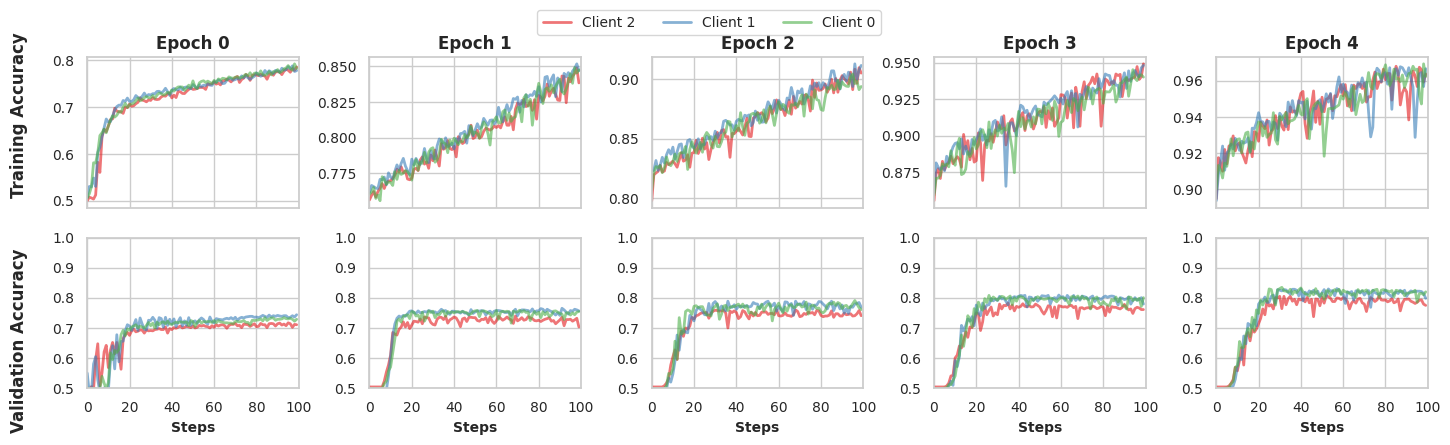

In [ ]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Initialize the API
api = wandb.Api()

# Specify the entity and project
entity = "raihanrabby"
project = "Beta_time_domain_CNN_Lstm"

# Fetch all runs from the project
runs = api.runs(f"{entity}/{project}")

# List to store the dataframes
dataframes = []

# Iterate over each run and fetch the history
for run in runs:
    # Fetch the history for each run
    history = run.history()

    # Add columns to identify the run, model name, epoch, and client
    history['run_id'] = run.id
    history['model_name'] = run.name

    # Extract epoch and client from model name
    match = re.match(r'epoch_(\d+)_client_(\d+)', run.name)
    if match:
        history['epoch_number'] = int(match.group(1))
        history['client_number'] = int(match.group(2))
    else:
        history['epoch_number'] = None
        history['client_number'] = None

    # Append to the list of dataframes
    dataframes.append(history)

# Concatenate all dataframes into a single dataframe
all_metrics_df = pd.concat(dataframes)

# Filter out rows with None epoch_number
all_metrics_df = all_metrics_df.dropna(subset=['epoch_number'])

# Get the unique epochs
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Set the Seaborn style
sns.set(style="whitegrid")

# Create subplots for each epoch
fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

# Set the color palette
palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

# Store the lines and labels for the legend
lines = []
labels = []

# Iterate through each epoch and plot the training and validation accuracy
for i, epoch in enumerate(unique_epochs):
    epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
    for j, client in enumerate(epoch_df['client_number'].unique()):
        client_df = epoch_df[epoch_df['client_number'] == client]
        line, = axes[0, i].plot(client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
        axes[1, i].plot(client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

        if i == 0:
            lines.append(line)
            labels.append(f'Client {client}')

    axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
    axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
    axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
    # axes[0, i].set_ylim(0.5)  # Ensure y-axis covers full range of accuracy
    axes[1, i].set_ylim(0.5, 1.0)  # Ensure y-axis covers full range of accuracy
    axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
    axes[0, i].grid(True)
    axes[1, i].grid(True)
    axes[0, i].tick_params(axis='both', which='major', labelsize=10)
    axes[1, i].tick_params(axis='both', which='major', labelsize=10)

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

# Add row labels
fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot
plt.show()


# CNN

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/CNN/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/CNN/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 18, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 256)            0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 18ms/step - loss: 1.6787 - accuracy: 0.7320 - val_loss: 1.7510 - val_accuracy: 0.6422
Epoch 3/100
29/29 [==============================] - 1s 21ms/step - loss: 1.6308 - accuracy: 0.7430 - val_loss: 1.7372 - val_accuracy: 0.6121
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 1.5973 - accuracy: 0.7505 - val_loss: 1.7217 - val_accuracy: 0.7252
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 1.5704 - accuracy: 0.7554 - val_loss: 1.7061 - val_accuracy: 0.7511
Epoch 6/100
29/29 [==============================] - 1s 38ms/step - loss: 1.5493 - accuracy: 0.7640 - val_loss: 1.6906 - val_accuracy: 0.7629
Epoch 7/100
29/29 [==============================] - 1s 40ms/step - loss: 1.5275 - accuracy: 0.7753 - val_loss: 1.6733 - val_accuracy: 0.7834
Epoch 8/100
29/29 [==============================] - 1s 27ms/step - loss: 1.5085 - accuracy: 0.7799 - val_loss: 1.6573 - val_accuracy: 0.7985
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 17ms/step - loss: 1.7043 - accuracy: 0.7049 - val_loss: 1.7536 - val_accuracy: 0.5158
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 1.6662 - accuracy: 0.7159 - val_loss: 1.7415 - val_accuracy: 0.6425
Epoch 4/100
28/28 [==============================] - 0s 17ms/step - loss: 1.6345 - accuracy: 0.7221 - val_loss: 1.7292 - val_accuracy: 0.6652
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 1.6099 - accuracy: 0.7306 - val_loss: 1.7158 - val_accuracy: 0.7376
Epoch 6/100
28/28 [==============================] - 0s 18ms/step - loss: 1.5863 - accuracy: 0.7442 - val_loss: 1.7026 - val_accuracy: 0.7443
Epoch 7/100
28/28 [==============================] - 0s 18ms/step - loss: 1.5666 - accuracy: 0.7561 - val_loss: 1.6884 - val_accuracy: 0.7579
Epoch 8/100
28/28 [==============================] - 0s 10ms/step - loss: 1.5468 - accuracy: 0.7586 - val_loss: 1.6739 - val_accuracy: 0.7557
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 12ms/step - loss: 1.6896 - accuracy: 0.7065 - val_loss: 1.7520 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 1.6510 - accuracy: 0.7072 - val_loss: 1.7384 - val_accuracy: 0.6488
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 1.6178 - accuracy: 0.7233 - val_loss: 1.7247 - val_accuracy: 0.6684
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 1.5890 - accuracy: 0.7362 - val_loss: 1.7102 - val_accuracy: 0.6921
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 1.5619 - accuracy: 0.7550 - val_loss: 1.6937 - val_accuracy: 0.7469
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 1.5351 - accuracy: 0.7680 - val_loss: 1.6771 - val_accuracy: 0.7386
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 1.5114 - accuracy: 0.7744 - val_loss: 1.6581 - val_accuracy: 0.7614
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 14ms/step - loss: 0.8705 - accuracy: 0.8526 - val_loss: 1.1903 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.8613 - accuracy: 0.8502 - val_loss: 1.1673 - val_accuracy: 0.5172
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8526 - accuracy: 0.8588 - val_loss: 1.1559 - val_accuracy: 0.5280
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 0.8405 - accuracy: 0.8588 - val_loss: 1.1358 - val_accuracy: 0.6929
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.8348 - accuracy: 0.8666 - val_loss: 1.1177 - val_accuracy: 0.7845
Epoch 7/100
29/29 [==============================] - 1s 18ms/step - loss: 0.8267 - accuracy: 0.8661 - val_loss: 1.0948 - val_accuracy: 0.8330
Epoch 8/100
29/29 [==============================] - 0s 11ms/step - loss: 0.8220 - accuracy: 0.8696 - val_loss: 1.0810 - val_accuracy: 0.8244
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 11ms/step - loss: 0.8831 - accuracy: 0.8461 - val_loss: 1.1884 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.8759 - accuracy: 0.8497 - val_loss: 1.1726 - val_accuracy: 0.5294
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.8629 - accuracy: 0.8551 - val_loss: 1.1585 - val_accuracy: 0.5724
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.8557 - accuracy: 0.8531 - val_loss: 1.1446 - val_accuracy: 0.6742
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.8494 - accuracy: 0.8594 - val_loss: 1.1262 - val_accuracy: 0.7952
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.8414 - accuracy: 0.8605 - val_loss: 1.1145 - val_accuracy: 0.8020
Epoch 8/100
28/28 [==============================] - 0s 16ms/step - loss: 0.8373 - accuracy: 0.8616 - val_loss: 1.0947 - val_accuracy: 0.8235
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 16ms/step - loss: 0.8586 - accuracy: 0.8581 - val_loss: 1.1877 - val_accuracy: 0.4886
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.8488 - accuracy: 0.8610 - val_loss: 1.1714 - val_accuracy: 0.5114
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.8436 - accuracy: 0.8623 - val_loss: 1.1536 - val_accuracy: 0.5940
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.8308 - accuracy: 0.8659 - val_loss: 1.1351 - val_accuracy: 0.7397
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.8245 - accuracy: 0.8677 - val_loss: 1.1167 - val_accuracy: 0.7831
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8204 - accuracy: 0.8682 - val_loss: 1.0964 - val_accuracy: 0.8357
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 0.8108 - accuracy: 0.8724 - val_loss: 1.0769 - val_accuracy: 0.8337
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 20ms/step - loss: 0.5374 - accuracy: 0.9230 - val_loss: 1.0034 - val_accuracy: 0.4871
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.5320 - accuracy: 0.9291 - val_loss: 0.9768 - val_accuracy: 0.4957
Epoch 4/100
29/29 [==============================] - 1s 22ms/step - loss: 0.5397 - accuracy: 0.9189 - val_loss: 0.9430 - val_accuracy: 0.5334
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.5222 - accuracy: 0.9324 - val_loss: 0.9223 - val_accuracy: 0.5905
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.5191 - accuracy: 0.9337 - val_loss: 0.8935 - val_accuracy: 0.7144
Epoch 7/100
29/29 [==============================] - 0s 9ms/step - loss: 0.5151 - accuracy: 0.9353 - val_loss: 0.8826 - val_accuracy: 0.6983
Epoch 8/100
29/29 [==============================] - 0s 11ms/step - loss: 0.5089 - accuracy: 0.9399 - val_loss: 0.8688 - val_accuracy: 0.7080
Epoch 9/100
29/29 [

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 17ms/step - loss: 0.5494 - accuracy: 0.9177 - val_loss: 1.0046 - val_accuracy: 0.4966
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.5546 - accuracy: 0.9103 - val_loss: 0.9750 - val_accuracy: 0.5124
Epoch 4/100
28/28 [==============================] - 0s 18ms/step - loss: 0.5417 - accuracy: 0.9177 - val_loss: 0.9544 - val_accuracy: 0.5339
Epoch 5/100
28/28 [==============================] - 0s 18ms/step - loss: 0.5306 - accuracy: 0.9298 - val_loss: 0.9272 - val_accuracy: 0.6143
Epoch 6/100
28/28 [==============================] - 0s 18ms/step - loss: 0.5256 - accuracy: 0.9281 - val_loss: 0.9097 - val_accuracy: 0.6833
Epoch 7/100
28/28 [==============================] - 0s 18ms/step - loss: 0.5218 - accuracy: 0.9307 - val_loss: 0.8916 - val_accuracy: 0.7059
Epoch 8/100
28/28 [==============================] - 0s 17ms/step - loss: 0.5238 - accuracy: 0.9307 - val_loss: 0.8768 - val_accuracy: 0.7545
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 16ms/step - loss: 0.5328 - accuracy: 0.9233 - val_loss: 1.0006 - val_accuracy: 0.4917
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.5288 - accuracy: 0.9266 - val_loss: 0.9702 - val_accuracy: 0.5052
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.5156 - accuracy: 0.9323 - val_loss: 0.9378 - val_accuracy: 0.5806
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.5189 - accuracy: 0.9331 - val_loss: 0.9127 - val_accuracy: 0.6694
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.5138 - accuracy: 0.9289 - val_loss: 0.8923 - val_accuracy: 0.7376
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 0.5078 - accuracy: 0.9344 - val_loss: 0.8664 - val_accuracy: 0.8192
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 0.5062 - accuracy: 0.9364 - val_loss: 0.8520 - val_accuracy: 0.8079
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 10ms/step - loss: 0.4009 - accuracy: 0.9612 - val_loss: 1.0435 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3923 - accuracy: 0.9669 - val_loss: 0.9868 - val_accuracy: 0.4935
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.3897 - accuracy: 0.9647 - val_loss: 0.9323 - val_accuracy: 0.5054
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3883 - accuracy: 0.9688 - val_loss: 0.9231 - val_accuracy: 0.5129
Epoch 6/100
29/29 [==============================] - 0s 16ms/step - loss: 0.3877 - accuracy: 0.9698 - val_loss: 0.9041 - val_accuracy: 0.5248
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3870 - accuracy: 0.9688 - val_loss: 0.8260 - val_accuracy: 0.6541
Epoch 8/100
29/29 [==============================] - 0s 11ms/step - loss: 0.3840 - accuracy: 0.9669 - val_loss: 0.8517 - val_accuracy: 0.5819
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 12ms/step - loss: 0.3972 - accuracy: 0.9584 - val_loss: 1.0382 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3944 - accuracy: 0.9618 - val_loss: 0.9893 - val_accuracy: 0.5034
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.3929 - accuracy: 0.9632 - val_loss: 0.9209 - val_accuracy: 0.5294
Epoch 5/100
28/28 [==============================] - 0s 18ms/step - loss: 0.3899 - accuracy: 0.9638 - val_loss: 0.9003 - val_accuracy: 0.5452
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.3852 - accuracy: 0.9683 - val_loss: 0.8997 - val_accuracy: 0.5475
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 0.3820 - accuracy: 0.9689 - val_loss: 0.8556 - val_accuracy: 0.5928
Epoch 8/100
28/28 [==============================] - 0s 17ms/step - loss: 0.3796 - accuracy: 0.9697 - val_loss: 0.8497 - val_accuracy: 0.5984
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 16ms/step - loss: 0.3873 - accuracy: 0.9625 - val_loss: 1.0358 - val_accuracy: 0.4866
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.3842 - accuracy: 0.9682 - val_loss: 0.9743 - val_accuracy: 0.4979
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.3800 - accuracy: 0.9674 - val_loss: 0.9172 - val_accuracy: 0.5248
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.3829 - accuracy: 0.9687 - val_loss: 0.8533 - val_accuracy: 0.6136
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 0.3899 - accuracy: 0.9636 - val_loss: 0.8715 - val_accuracy: 0.5630
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 0.3777 - accuracy: 0.9685 - val_loss: 0.8472 - val_accuracy: 0.6012
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 0.3789 - accuracy: 0.9695 - val_loss: 0.8499 - val_accuracy: 0.5961
Epoch 9/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
29/29 [==============================] - 0s 12ms/step - loss: 0.3207 - accuracy: 0.9846 - val_loss: 1.1483 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.3170 - accuracy: 0.9863 - val_loss: 1.0885 - val_accuracy: 0.4892
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.3191 - accuracy: 0.9830 - val_loss: 1.0283 - val_accuracy: 0.4968
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.3111 - accuracy: 0.9887 - val_loss: 0.9726 - val_accuracy: 0.5097
Epoch 6/100
29/29 [==============================] - 1s 26ms/step - loss: 0.3109 - accuracy: 0.9884 - val_loss: 0.9523 - val_accuracy: 0.5162
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.3099 - accuracy: 0.9884 - val_loss: 0.9144 - val_accuracy: 0.5334
Epoch 8/100
29/29 [==============================] - 1s 24ms/step - loss: 0.3041 - accuracy: 0.9914 - val_loss: 0.8953 - val_accuracy: 0.5517
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 0s 12ms/step - loss: 0.3282 - accuracy: 0.9799 - val_loss: 1.1366 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3207 - accuracy: 0.9819 - val_loss: 1.0842 - val_accuracy: 0.5000
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 0.3166 - accuracy: 0.9833 - val_loss: 1.0379 - val_accuracy: 0.5090
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3166 - accuracy: 0.9847 - val_loss: 0.9623 - val_accuracy: 0.5294
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3105 - accuracy: 0.9884 - val_loss: 0.9304 - val_accuracy: 0.5430
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 0.3146 - accuracy: 0.9850 - val_loss: 0.9281 - val_accuracy: 0.5498
Epoch 8/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3073 - accuracy: 0.9890 - val_loss: 0.9443 - val_accuracy: 0.5532
Epoch 9/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 18ms/step - loss: 0.3150 - accuracy: 0.9845 - val_loss: 1.1578 - val_accuracy: 0.4866
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.3122 - accuracy: 0.9871 - val_loss: 1.0600 - val_accuracy: 0.4979
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3063 - accuracy: 0.9915 - val_loss: 0.9724 - val_accuracy: 0.5155
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.3062 - accuracy: 0.9891 - val_loss: 0.9275 - val_accuracy: 0.5320
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 0.3046 - accuracy: 0.9886 - val_loss: 0.9513 - val_accuracy: 0.5310
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3188 - accuracy: 0.9801 - val_loss: 0.9073 - val_accuracy: 0.5579
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 0.3038 - accuracy: 0.9907 - val_loss: 0.9335 - val_accuracy: 0.5496
Epoch 9/100
31/31 

In [ ]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.755,0.759,0.745,0.752,0.745,0.764,0.509
1,1,0.809,0.792,0.838,0.814,0.838,0.780,0.617
2,2,0.728,0.718,0.751,0.734,0.751,0.705,0.456
3,0,0.815,0.813,0.817,0.815,0.817,0.812,0.630
4,1,0.833,0.793,0.901,0.843,0.901,0.764,0.665
5,2,0.762,0.736,0.817,0.775,0.817,0.707,0.524
6,0,0.844,0.831,0.864,0.847,0.864,0.824,0.688
7,1,0.869,0.897,0.833,0.864,0.833,0.904,0.737
8,2,0.797,0.747,0.898,0.816,0.898,0.697,0.594
9,0,0.861,0.837,0.896,0.866,0.896,0.826,0.722


In [ ]:
metrics_df_CNN.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Time Domain/CNN/Theta_time_CNN.csv', index = False)

#CNN_GRU

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model_gru(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning_gru(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model_gru(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model_gru(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/GRU/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/Time_domain/Total/GRU/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [ ]:
global_model_gru, metrics_df_gru = federated_learning_gru(Theta_data)

Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Train shape: (4640, 18, 29), Test shape: (1194, 18, 29)
Train shape: (4418, 18, 29), Test shape: (1416, 18, 29)
Train shape: (4838, 18, 29), Test shape: (996, 18, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 18, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 256)            0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 1s 19ms/step - loss: 1.4180 - accuracy: 0.6487 - val_loss: 1.4223 - val_accuracy: 0.4957
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 1.4015 - accuracy: 0.7010 - val_loss: 1.4160 - val_accuracy: 0.5733
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 1.3731 - accuracy: 0.7204 - val_loss: 1.4078 - val_accuracy: 0.6897
Epoch 5/100
29/29 [==============================] - 1s 21ms/step - loss: 1.3364 - accuracy: 0.7352 - val_loss: 1.3967 - val_accuracy: 0.7177
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 1.2966 - accuracy: 0.7384 - val_loss: 1.3822 - val_accuracy: 0.7317
Epoch 7/100
29/29 [==============================] - 1s 19ms/step - loss: 1.2671 - accuracy: 0.7425 - val_loss: 1.3649 - val_accuracy: 0.7597
Epoch 8/100
29/29 [==============================] - 0s 11ms/step - loss: 1.2470 - accuracy: 0.7460 - val_loss: 1.3494 - val_accuracy: 0.7554
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 75ms/step - loss: 1.4298 - accuracy: 0.5690 - val_loss: 1.4283 - val_accuracy: 0.5882
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 1.4210 - accuracy: 0.6245 - val_loss: 1.4228 - val_accuracy: 0.5249
Epoch 3/100
28/28 [==============================] - 1s 20ms/step - loss: 1.4097 - accuracy: 0.6718 - val_loss: 1.4172 - val_accuracy: 0.6324
Epoch 4/100
28/28 [==============================] - 1s 22ms/step - loss: 1.3920 - accuracy: 0.6921 - val_loss: 1.4106 - val_accuracy: 0.6821
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 1.3683 - accuracy: 0.6981 - val_loss: 1.4024 - val_accuracy: 0.7161
Epoch 6/100
28/28 [==============================] - 0s 13ms/step - loss: 1.3385 - accuracy: 0.7054 - val_loss: 1.3922 - val_accuracy: 0.6957
Epoch 7/100
28/28 [==============================] - 1s 24ms/step - loss: 1.3102 - accuracy: 0.7128 - val_loss: 1.3800 - val_accuracy: 0.7172
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 1.4192 - accuracy: 0.6323 - val_loss: 1.4218 - val_accuracy: 0.4845
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 1.4053 - accuracy: 0.6628 - val_loss: 1.4157 - val_accuracy: 0.4845
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 1.3839 - accuracy: 0.6829 - val_loss: 1.4083 - val_accuracy: 0.6436
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 1.3542 - accuracy: 0.6941 - val_loss: 1.3990 - val_accuracy: 0.6808
Epoch 6/100
31/31 [==============================] - 1s 28ms/step - loss: 1.3217 - accuracy: 0.7054 - val_loss: 1.3865 - val_accuracy: 0.7097
Epoch 7/100
31/31 [==============================] - 1s 35ms/step - loss: 1.2906 - accuracy: 0.7168 - val_loss: 1.3732 - val_accuracy: 0.7159
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 1.2657 - accuracy: 0.7274 - val_loss: 1.3583 - val_accuracy: 0.7304
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 0s 13ms/step - loss: 0.7928 - accuracy: 0.8489 - val_loss: 1.1135 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7896 - accuracy: 0.8502 - val_loss: 1.1001 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.7867 - accuracy: 0.8475 - val_loss: 1.0838 - val_accuracy: 0.4957
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.7853 - accuracy: 0.8435 - val_loss: 1.0740 - val_accuracy: 0.5097
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.7781 - accuracy: 0.8502 - val_loss: 1.0590 - val_accuracy: 0.6692
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.7788 - accuracy: 0.8505 - val_loss: 1.0417 - val_accuracy: 0.8211
Epoch 8/100
29/29 [==============================] - 0s 13ms/step - loss: 0.7726 - accuracy: 0.8494 - val_loss: 1.0296 - val_accuracy: 0.7716
Epoch 9/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 54ms/step - loss: 0.8174 - accuracy: 0.8387 - val_loss: 1.1287 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 13ms/step - loss: 0.8061 - accuracy: 0.8384 - val_loss: 1.1140 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.7986 - accuracy: 0.8461 - val_loss: 1.1001 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7965 - accuracy: 0.8435 - val_loss: 1.0886 - val_accuracy: 0.4966
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7854 - accuracy: 0.8500 - val_loss: 1.0752 - val_accuracy: 0.5588
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.7797 - accuracy: 0.8478 - val_loss: 1.0646 - val_accuracy: 0.5928
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 0.7791 - accuracy: 0.8503 - val_loss: 1.0535 - val_accuracy: 0.6900
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 67ms/step - loss: 0.8061 - accuracy: 0.8408 - val_loss: 1.1278 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.7958 - accuracy: 0.8375 - val_loss: 1.1110 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 0s 13ms/step - loss: 0.7841 - accuracy: 0.8450 - val_loss: 1.1000 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 0.7807 - accuracy: 0.8486 - val_loss: 1.0832 - val_accuracy: 0.5165
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.7724 - accuracy: 0.8496 - val_loss: 1.0689 - val_accuracy: 0.5950
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.7666 - accuracy: 0.8494 - val_loss: 1.0562 - val_accuracy: 0.6529
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.7647 - accuracy: 0.8475 - val_loss: 1.0469 - val_accuracy: 0.6281
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 49ms/step - loss: 0.5351 - accuracy: 0.8982 - val_loss: 0.9914 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 13ms/step - loss: 0.5207 - accuracy: 0.9111 - val_loss: 0.9640 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.5192 - accuracy: 0.9068 - val_loss: 0.9409 - val_accuracy: 0.4871
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 0.5188 - accuracy: 0.9073 - val_loss: 0.9191 - val_accuracy: 0.5140
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.5112 - accuracy: 0.9122 - val_loss: 0.9108 - val_accuracy: 0.5334
Epoch 6/100
29/29 [==============================] - 1s 28ms/step - loss: 0.5075 - accuracy: 0.9124 - val_loss: 0.8984 - val_accuracy: 0.5668
Epoch 7/100
29/29 [==============================] - 1s 27ms/step - loss: 0.5122 - accuracy: 0.9041 - val_loss: 0.8807 - val_accuracy: 0.6239
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 52ms/step - loss: 0.5490 - accuracy: 0.8973 - val_loss: 0.9923 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.5382 - accuracy: 0.8953 - val_loss: 0.9695 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.5302 - accuracy: 0.8973 - val_loss: 0.9467 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 0.5213 - accuracy: 0.9055 - val_loss: 0.9307 - val_accuracy: 0.5023
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 0.5124 - accuracy: 0.9075 - val_loss: 0.9234 - val_accuracy: 0.5147
Epoch 6/100
28/28 [==============================] - 1s 23ms/step - loss: 0.5122 - accuracy: 0.9078 - val_loss: 0.9035 - val_accuracy: 0.5803
Epoch 7/100
28/28 [==============================] - 1s 27ms/step - loss: 0.5069 - accuracy: 0.9111 - val_loss: 0.8964 - val_accuracy: 0.5871
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 50ms/step - loss: 0.5510 - accuracy: 0.8881 - val_loss: 0.9926 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.5209 - accuracy: 0.9044 - val_loss: 0.9647 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 0.5178 - accuracy: 0.9036 - val_loss: 0.9476 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5208 - accuracy: 0.9026 - val_loss: 0.9217 - val_accuracy: 0.5279
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 0.5063 - accuracy: 0.9106 - val_loss: 0.9045 - val_accuracy: 0.5775
Epoch 6/100
31/31 [==============================] - 1s 26ms/step - loss: 0.5095 - accuracy: 0.9075 - val_loss: 0.8872 - val_accuracy: 0.6405
Epoch 7/100
31/31 [==============================] - 1s 27ms/step - loss: 0.5000 - accuracy: 0.9078 - val_loss: 0.8676 - val_accuracy: 0.7149
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3880 - accuracy: 0.9378 - val_loss: 0.9289 - val_accuracy: 0.4860
Epoch 3/100
29/29 [==============================] - 0s 12ms/step - loss: 0.3715 - accuracy: 0.9448 - val_loss: 0.9055 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.3709 - accuracy: 0.9429 - val_loss: 0.8854 - val_accuracy: 0.4968
Epoch 5/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3675 - accuracy: 0.9459 - val_loss: 0.8579 - val_accuracy: 0.5216
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.3569 - accuracy: 0.9561 - val_loss: 0.8413 - val_accuracy: 0.5474
Epoch 7/100
29/29 [==============================] - 1s 21ms/step - loss: 0.3536 - accuracy: 0.9566 - val_loss: 0.8280 - val_accuracy: 0.5700
Epoch 8/100
29/29 [==============================] - 0s 12ms/step - loss: 0.3544 - accuracy: 0.9529 - val_loss: 0.8273 - val_accuracy: 0.5668
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 56ms/step - loss: 0.4107 - accuracy: 0.9281 - val_loss: 0.9574 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 14ms/step - loss: 0.3672 - accuracy: 0.9448 - val_loss: 0.9418 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 14ms/step - loss: 0.3654 - accuracy: 0.9493 - val_loss: 0.9127 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 0.3743 - accuracy: 0.9431 - val_loss: 0.8897 - val_accuracy: 0.5000
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.3628 - accuracy: 0.9493 - val_loss: 0.8820 - val_accuracy: 0.5136
Epoch 6/100
28/28 [==============================] - 1s 24ms/step - loss: 0.3606 - accuracy: 0.9508 - val_loss: 0.8623 - val_accuracy: 0.5249
Epoch 7/100
28/28 [==============================] - 1s 24ms/step - loss: 0.3598 - accuracy: 0.9505 - val_loss: 0.8389 - val_accuracy: 0.5679
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 61ms/step - loss: 0.3998 - accuracy: 0.9336 - val_loss: 0.9674 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3763 - accuracy: 0.9442 - val_loss: 0.9448 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 25ms/step - loss: 0.3740 - accuracy: 0.9408 - val_loss: 0.9160 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 0.3600 - accuracy: 0.9506 - val_loss: 0.8776 - val_accuracy: 0.5114
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 0.3647 - accuracy: 0.9444 - val_loss: 0.8564 - val_accuracy: 0.5300
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.3668 - accuracy: 0.9447 - val_loss: 0.8397 - val_accuracy: 0.5579
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.3660 - accuracy: 0.9450 - val_loss: 0.8695 - val_accuracy: 0.5289
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 51ms/step - loss: 0.3070 - accuracy: 0.9615 - val_loss: 0.9806 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 12ms/step - loss: 0.3120 - accuracy: 0.9585 - val_loss: 0.9434 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 0.2980 - accuracy: 0.9661 - val_loss: 0.9151 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 1s 20ms/step - loss: 0.2927 - accuracy: 0.9644 - val_loss: 0.8819 - val_accuracy: 0.4978
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.2765 - accuracy: 0.9741 - val_loss: 0.8660 - val_accuracy: 0.5097
Epoch 6/100
29/29 [==============================] - 1s 20ms/step - loss: 0.2791 - accuracy: 0.9736 - val_loss: 0.8363 - val_accuracy: 0.5366
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.2845 - accuracy: 0.9723 - val_loss: 0.8214 - val_accuracy: 0.5517
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 10s 56ms/step - loss: 0.3464 - accuracy: 0.9448 - val_loss: 0.9540 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 16ms/step - loss: 0.3066 - accuracy: 0.9607 - val_loss: 0.9435 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - loss: 0.2835 - accuracy: 0.9703 - val_loss: 0.9172 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.2772 - accuracy: 0.9731 - val_loss: 0.8981 - val_accuracy: 0.4989
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 0.2806 - accuracy: 0.9686 - val_loss: 0.8841 - val_accuracy: 0.5136
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 0.2817 - accuracy: 0.9728 - val_loss: 0.8698 - val_accuracy: 0.5204
Epoch 7/100
28/28 [==============================] - 1s 22ms/step - loss: 0.2756 - accuracy: 0.9720 - val_loss: 0.8646 - val_accuracy: 0.5283
Epoch 8/100
28/28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 65ms/step - loss: 0.3165 - accuracy: 0.9571 - val_loss: 0.9687 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.3036 - accuracy: 0.9607 - val_loss: 0.9379 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 0.2905 - accuracy: 0.9680 - val_loss: 0.8881 - val_accuracy: 0.4907
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 0.2854 - accuracy: 0.9705 - val_loss: 0.8981 - val_accuracy: 0.4990
Epoch 5/100
31/31 [==============================] - 1s 24ms/step - loss: 0.2870 - accuracy: 0.9677 - val_loss: 0.8669 - val_accuracy: 0.5176
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.2799 - accuracy: 0.9721 - val_loss: 0.8407 - val_accuracy: 0.5341
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 0.2955 - accuracy: 0.9605 - val_loss: 0.8535 - val_accuracy: 0.5382
Epoch 8/100
31/31 

In [ ]:
metrics_df_gru

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.746231,0.750000,0.738693,0.744304,0.738693,0.753769,0.492462
1,1,0.798729,0.782377,0.827684,0.804393,0.827684,0.769774,0.597458
2,2,0.730924,0.733740,0.724900,0.729293,0.724900,0.736948,0.461847
3,0,0.793132,0.802768,0.777219,0.789787,0.777219,0.809045,0.586265
4,1,0.812853,0.788036,0.855932,0.820582,0.855932,0.769774,0.625706
5,2,0.760040,0.733333,0.817269,0.773029,0.817269,0.702811,0.520080
6,0,0.807370,0.771852,0.872697,0.819182,0.872697,0.742044,0.614740
7,1,0.842514,0.822045,0.874294,0.847365,0.874294,0.810734,0.685028
8,2,0.817269,0.791513,0.861446,0.825000,0.861446,0.773092,0.634538
9,0,0.831658,0.800912,0.882747,0.839841,0.882747,0.780570,0.663317


In [ ]:
metrics_df_gru.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/Time Domain/CNN_GRU/time_CNN.csv', index = False)